# Лабораторная работа 3, Ковригина Софья, Б20-505

### Харакетеристики системы

```bash
machdep.cpu.brand_string: Apple M1
machdep.cpu.core_count: 8
machdep.cpu.cores_per_package: 8
machdep.cpu.logical_per_package: 8
machdep.cpu.thread_count: 8
```

In [4]:
CORE_LIMIT = 16
ELEMENT_TRIM = 5

import pandas as pd
import seaborn as sns

In [5]:
arr = []

with open("trace.txt", "r") as fd:
    for i in range(CORE_LIMIT):
        line = list(map(float, fd.readline().split(";")))
        line = sorted(line)[ELEMENT_TRIM:-ELEMENT_TRIM]
        avg_value = (sum(line) / len(line))
        arr.append(avg_value)

In [6]:
# Create DataFrames
cur_data = [[index+1, avg_time, "Calculated"] for index, avg_time in enumerate(arr)]
perf_data = cur_data.copy()
for i in range(1, len(perf_data)): 
    perf_data[i] = [perf_data[i][0], perf_data[0][1] / perf_data[i][0], "Perfect"]
perf_data[0] = [perf_data[0][0], perf_data[0][1], "Perfect"] 

curr_df = pd.DataFrame(cur_data, columns=["Threads", "Time", "Type"])
perf_df = pd.DataFrame(perf_data, columns=["Threads", "Time", "Type"])

all_df = pd.concat([curr_df, perf_df])

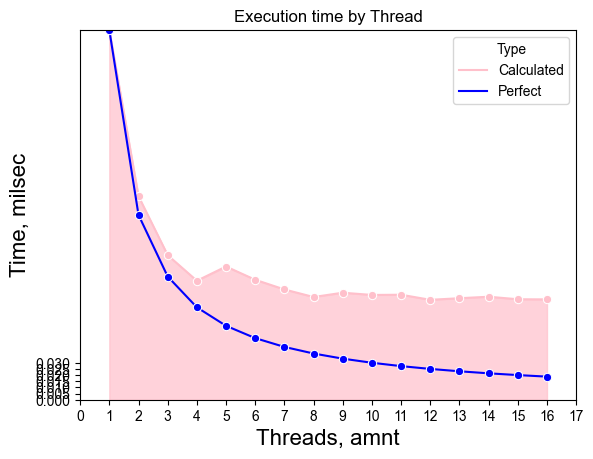

In [7]:
# Time graph
p = sns.lineplot(x="Threads", y="Time", hue="Type", palette=["pink", "blue"],marker="o", data=all_df)
p.set_xlabel("Threads, amnt", fontsize = 16)
p.set_ylabel("Time, milsec", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]
_ = p.fill_between(x1, y1, color="pink", alpha=0.7)
p.margins(x=0, y=0)
_ = p.set_xticks(range(0, CORE_LIMIT+2))
_ = p.set_xticklabels([str(i) for  i in range(CORE_LIMIT+2)])
_ = p.set_yticks([val*0.005 for val in range(7)])
sns.set(rc={'figure.figsize':(12,10)})
_ = p.set(title='Execution time by Thread')

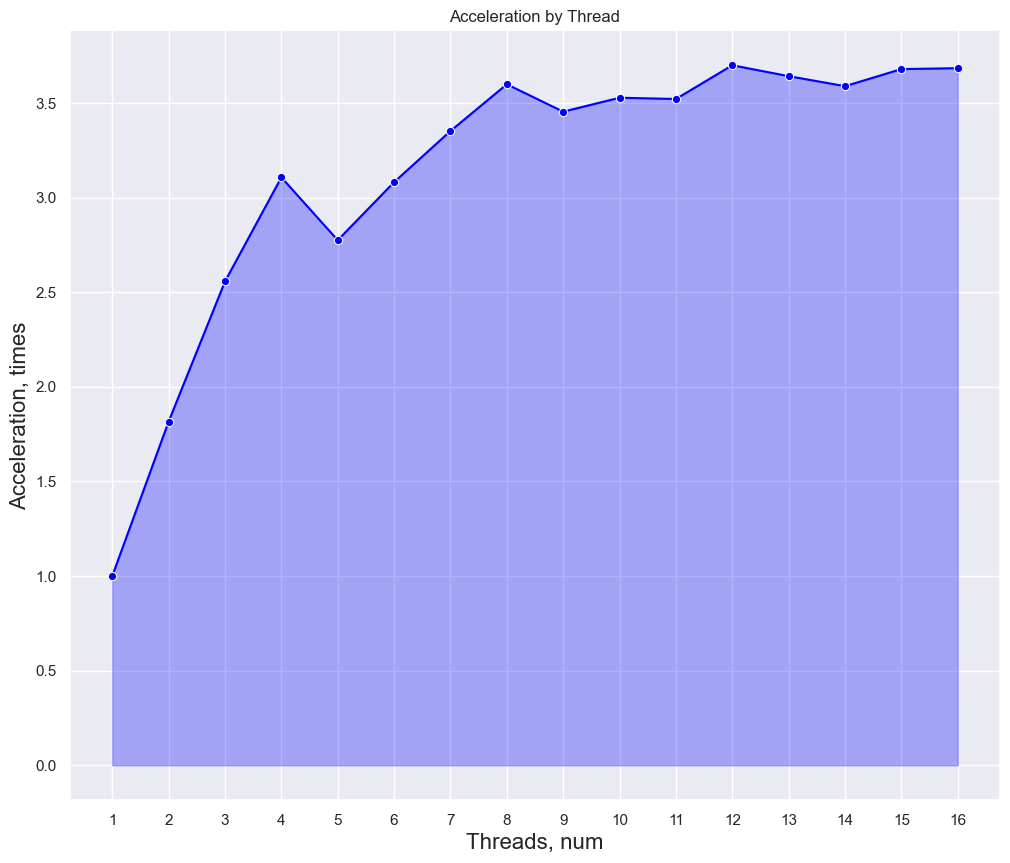

In [8]:
# Acceleration per thread
acceleration = [0] * CORE_LIMIT
for i in range(CORE_LIMIT):
    acceleration[i] = [cur_data[i][0], cur_data[0][1] / cur_data[i][1]]
acc_df = pd.DataFrame(acceleration, columns=["Threads", "Acceleration"])
p = sns.lineplot(x="Threads", y="Acceleration", marker="o", data=acc_df, color='blue')

p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("Acceleration, times", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

_ = p.set_xticks(range(0, CORE_LIMIT+2))
_ = p.set_xticklabels([str(i) for  i in range(CORE_LIMIT+2)])

_ = p.fill_between(x1, y1, color="blue", alpha=0.3)
_ = p.set(title='Acceleration by Thread')

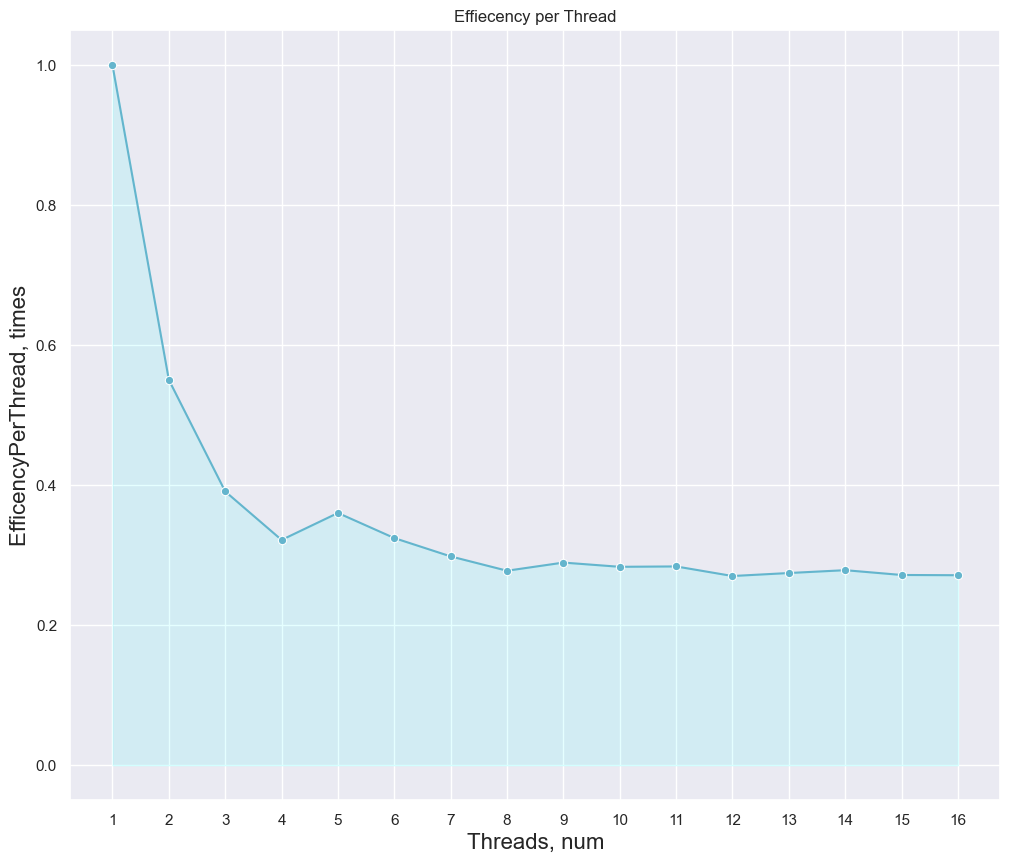

In [9]:
# Effiecency
effiecency = [0] * CORE_LIMIT
for i in range(CORE_LIMIT):
    effiecency[i] = [acceleration[i][0], acceleration[0][1] / acceleration[i][1]]


eff_df = pd.DataFrame(effiecency, columns=["Threads", "EfficencyPerThread"])
p = sns.lineplot(x="Threads", y="EfficencyPerThread", marker="o", data=eff_df, color='c')
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("EfficencyPerThread, times", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

_ = p.set_xticks(range(0, CORE_LIMIT+2))
_ = p.set_xticklabels([str(i) for  i in range(CORE_LIMIT+2)])

_ = p.fill_between(x1, y1, color="cyan", alpha=0.1)
_ = p.set(title='Effiecency per Thread')

## Заключение

В данной работе я познакомилась с разработкой параллельных алгоритмов сортировки. Была написана сортировка Шелла и произведены замеры производительности.

#### Выводы
- Параллелизм в алгоритмах сортировки наиболее эффективен(по сравнению с прочими рассмотренными задачами), поэтому параллельные сортировки - наиболее частый предмет исследования.
- В который раз я убедилась, что использование дополнительных потоков не всегда приводит к росту, а иногда и к падению производительности. 

### Код программы 

``` C
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

#define MROWS 100

void InsertSort(int *arr, int i, int length,  int half){
  int temp = 0;
  int j = 0;

  for (int f = half + i; f < length; f = f + half)
  {
    j = f;
    while(j > i && arr[j-half] > arr[j])
    {
      temp = arr[j];
      arr[j] = arr[j-half];
      arr[j-half] = temp;
      j = j -half;
    }
  }
}

double shellSortParallel(int *array, int length, int cur_threads)
{
  int h;
  int j = 0;
  int temp = 0;
  int i = 0;
  for(h =length/2; h > 0; h = h/2)
  {
    #pragma omp parallel for num_threads(cur_threads) shared(array, length, h, i)  default(none)
    for( i = 0; i < h; i++)
    {
      InsertSort(array, i, length, h);
    }
  }
}


int main(int argc, char** argv)
{
    const int count = 1000000;         ///< Number of array elements
    const int random_seed = 31337; ///< RNG seed

    int** matrix = 0;               ///< The array we need to find the max in
    srand(random_seed);
    double start, end;

    /* Generate the random MATRIX */
    matrix = (int**)calloc(MROWS, sizeof(int*));
    for (int i = 0; i < MROWS; i++) {
        matrix[i] = (int*)calloc(count, sizeof(int));
    }
    for (int i = 0; i < MROWS; i++) {
        for (int elem = 0; elem < count; elem++) {
            matrix[i][elem] = rand();
        }
    }

    char filename[50];
    sprintf(filename, "trace.txt");
    FILE *fp = fopen(filename, "w");
    if (fp == NULL) {
        printf("Can't open file\n");
        exit(1);
    }
    int threads = omp_get_max_threads() * 2;

    for (int thread = 1; thread <= threads; thread++) {
        printf("<--- START FOR %d THREADS --->\n", thread);
        // create matrix for each thread

        for (int row = 0; row < MROWS; row++) {
            int *curr_arr = calloc(count, sizeof(int));
            for (int i = 0; i < count; i++) {
                curr_arr[i] = matrix[row][i];
            }
            start = omp_get_wtime();
            
            shellSortParallel(curr_arr, count, thread);

            end = omp_get_wtime();
            if (row != MROWS - 1) {
                fprintf(fp, "%f;", end-start);
            } else {
                fprintf(fp, "%f\n", end-start);
            }
            // for (int i = 0; i < count; i ++) {
            //     printf("%d | ", curr_arr[i]);
            // }
            free(curr_arr);
        }
    }
    fclose(fp);
    printf("Exit...\n");
    return(0);
}
```